### Import libraries

In [167]:
import json, datetime, os, zipfile
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

#Machine learning methods
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.linear_model import LogisticRegression as lr
from sklearn.ensemble import GradientBoostingClassifier as gbm
from sklearn.metrics import roc_auc_score, roc_curve, classification_report

#joblib
from sklearn.externals import joblib

### Unzip files to a folder

In [140]:
zipf = zipfile.ZipFile('interconnect_json.zip')
zipf.extractall('Data')
zipf.close()

### Exploratory analysis
#### Check how many files there are..

In [2]:
files = os.listdir('Data')
print len(files)

99


#### Aggregate bond counts and pass rates from each file, and check distribution of pass rate

In [3]:
bond_count = []
pass_rate = []
for ff in files:
    with open(os.path.join('Data',ff), 'r') as f:
        data = json.load(f)
    f.close()
    bonds = data['BONDS']
    count = int(data['BOND_COUNT'])
    trace_count_all = []
    test_status_all = []
    for bond in bonds:
        trace_count_all.append(int(bond['TRACE_SAMPLE_COUNT']))
        test_status = 1 if bond['PULL_TEST_STATUS'] == "Pass" else 0
        test_status_all.append(test_status)
    rate = np.sum(test_status_all)/float(count)
    
    bond_count.append(count)
    pass_rate.append(rate)

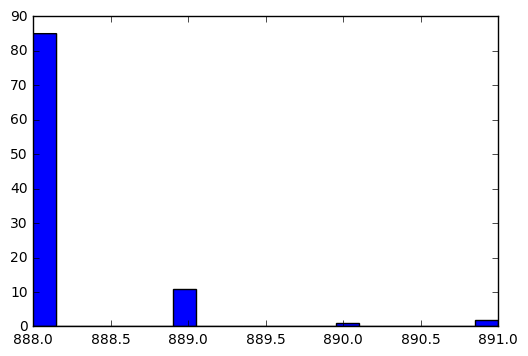

In [4]:
plt.hist(bond_count, bins=20)
plt.show()

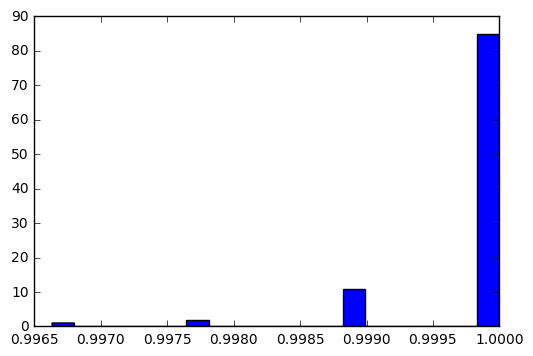

In [5]:
plt.hist(pass_rate, bins=20)
plt.show()

#### Pass rate looks great, which means the dataset is imbalanced for classification and Fail is a rare class.
#### I want to see overall just how many passes and how many bonds there are

In [6]:
total_pass = np.sum(map(lambda (count, rate): count*rate, zip(bond_count, pass_rate)))
print total_pass

total_count = np.sum(bond_count)
print total_count

### as shown below, out of 87931 bonds, only 18 bonds have status Fail

87913.0
87931


### Getting raw data
#### Next, I'll proceed to extract bond level data and its corresponding status. Sample level data points are combined to generate a dataframe for each bond

In [7]:
bond_data = []
bond_flag = []
bond_id = []
for ff in files:
    with open(os.path.join('Data',ff), 'r') as f:
        data = json.load(f)
    f.close()
    bonds = data['BONDS']
    file_id = data['FILE_ID']
    for bond in bonds:
        #numerical test status, note the binary encoding is changed where Fail is a Positive 
        test_status_bond = 0 if bond['PULL_TEST_STATUS'] == "Pass" else 1
        #convert sample data to dataframe
        sample = bond['TRACE_SAMPLES']
        df = pd.DataFrame.from_dict(sample)
        #keep track of ID
        BOND_ID = bond['BOND_ID']
        
        bond_flag += [test_status_bond]
        bond_data += [df]
        bond_id += [(file_id, BOND_ID)]

In [8]:
print bond_id[:5]
print bond_flag[:5]
print [dft.head(5) for dft in bond_data[:5]]

[(1, 1), (1, 9), (1, 17), (1, 25), (1, 33)]
[0, 0, 0, 0, 0]
[   ALCPT   DFRM  DRIV   FREQ  PHAS  SAMPLE   US  VOLT
0    NaN -101.5  1350  81.55   0.0       1  307   158
1    NaN -102.0  1350  81.57   0.0       2  304   158
2    NaN -102.5  1350  81.57   0.0       3  302   158
3    NaN -102.5  1350  81.58   0.0       4  300   158
4    NaN -103.0  1350  81.59   0.0       5  298   158,    ALCPT   DFRM  DRIV   FREQ  PHAS  SAMPLE   US  VOLT
0    NaN -118.0   950  81.39  0.00       1  411   107
1    NaN -118.5   950  81.42  0.49       2  411   107
2    NaN -118.5   950  81.41  0.00       3  410   107
3    NaN -119.0   950  81.41  0.00       4  409   107
4    NaN -119.5   950  81.41  0.00       5  408   107,    ALCPT   DFRM  DRIV   FREQ  PHAS  SAMPLE   US  VOLT
0    NaN -110.0  1350  81.45   0.0       1  341   154
1    NaN -110.0  1350  81.46   0.0       2  340   154
2    NaN -110.5  1350  81.48   0.0       3  338   155
3    NaN -110.5  1350  81.48   0.0       4  337   155
4    NaN -110.5  13

### Feature engineering
#### For each variable in the raw data, a number of features are created below, to reduce the row number to 1 for each dataframe but increase the number of column

In [9]:
# definition of what features to extract
def fe(dft):
    feat_vec = {}
    attr = ['mean', 'min', 'max', 'std', 'kurt']
    for col in dft.columns:
        if col == 'SAMPLE':
            continue
        
        for att in attr:
            feat_vec[col+'_'+att] = getattr(dft[col], att)()
        
        feat_vec[col+'_rms'] = np.sqrt(np.sum(dft[col]**2)/len(dft))
        feat_vec['sample_no'] = np.max(np.max(dft['SAMPLE']))
        
    return feat_vec
            
tmp = fe(dft)
print tmp

{u'ALCPT_max': 31.5, u'US_max': 1019, u'PHAS_min': -0.48999999999999999, u'VOLT_std': 35.25304435740726, u'DFRM_kurt': 2.0457430308782296, u'VOLT_min': 1, u'DFRM_min': -121.0, u'PHAS_rms': 0.14425209415002149, u'US_std': 180.47607983192364, u'FREQ_kurt': -0.32488399629308473, u'US_kurt': 5.7334121201150223, u'PHAS_std': 0.14469823571261864, u'VOLT_max': 159, u'ALCPT_kurt': 0.44212536849171613, u'ALCPT_mean': 22.258333333333333, u'ALCPT_std': 9.113917308192178, u'DFRM_mean': -95.55666666666667, u'US_mean': 328.4266666666667, u'ALCPT_min': 0.0, u'PHAS_kurt': 8.8620851783376047, u'DRIV_kurt': 8.2890362489170286, u'VOLT_kurt': 7.2730827942433018, u'PHAS_max': 0.48999999999999999, u'FREQ_min': 80.329999999999998, 'sample_no': 150, u'DRIV_min': 59, u'DRIV_mean': 1251.5733333333333, u'VOLT_mean': 143.72666666666666, u'PHAS_mean': -0.003266666666666668, u'DFRM_max': 0.0, u'DFRM_std': 35.239617761196804, u'DRIV_rms': 1282.8756759717598, u'DRIV_std': 282.6072842947708, u'DFRM_rms': 101.806818697

#### Feature extraction from raw data

In [10]:
feat = [fe(dft) for dft in bond_data]
print feat[:5]

[{u'ALCPT_max': 34.0, u'US_max': 1205, u'PHAS_min': -0.48999999999999999, u'VOLT_std': 35.39671555435327, u'DFRM_kurt': 2.0414215989180908, u'VOLT_min': 1, u'DFRM_min': -114.0, u'PHAS_rms': 0.098000000000000004, u'US_std': 226.68628313589838, u'FREQ_kurt': -0.15331040608253499, u'US_kurt': 5.5191705141872651, u'PHAS_std': 0.09810955844673347, u'VOLT_max': 159, u'ALCPT_kurt': 0.71883369336191638, u'ALCPT_mean': 24.483333333333334, u'ALCPT_std': 9.15773576239156, u'DFRM_mean': -90.69333333333333, u'US_mean': 343.6533333333333, u'ALCPT_min': 0.0, u'PHAS_kurt': 22.587804222023191, u'DRIV_kurt': 8.2890362489170286, u'VOLT_kurt': 7.0294601468032445, u'PHAS_max': 0.48999999999999999, u'FREQ_min': 80.269999999999996, 'sample_no': 150, u'DRIV_min': 59, u'DRIV_mean': 1251.5733333333333, u'VOLT_mean': 143.40666666666667, u'PHAS_mean': -0.006533333333333333, u'DFRM_max': 0.0, u'DFRM_std': 33.1507025984978, u'DRIV_rms': 1282.8756759717598, u'DRIV_std': 282.6072842947708, u'DFRM_rms': 96.52421112515

#### Convert the list of features to a dataframe using the *from_dict* method

In [11]:
df_feat = pd.DataFrame.from_dict(feat)
print df_feat.head(5)
print df_feat.shape

   ALCPT_kurt  ALCPT_max  ALCPT_mean  ALCPT_min  ALCPT_rms  ALCPT_std  \
0    0.718834       34.0   24.483333        0.0  16.515447   9.157736   
1    1.270343       26.0   19.433333        0.0  15.525708   6.702812   
2    0.363003       35.5   25.241667        0.0  17.378675  10.949999   
3    0.740719       28.0   21.783333        0.0  17.709830   8.695590   
4    0.442125       31.5   22.258333        0.0  15.193584   9.113917   

   DFRM_kurt  DFRM_max   DFRM_mean  DFRM_min    ...      US_min      US_rms  \
0   2.041422       0.0  -90.693333    -114.0    ...           0  411.267553   
1   3.944647       0.0 -102.266667    -125.5    ...          60  426.009390   
2   2.138088       0.0  -97.080000    -123.0    ...           0  365.516074   
3   3.537289       0.0 -109.428571    -134.5    ...          55  400.830388   
4   2.045743       0.0  -95.556667    -121.0    ...           0  374.456940   

       US_std  VOLT_kurt  VOLT_max   VOLT_mean  VOLT_min    VOLT_rms  \
0  226.686283 

#### Checking how many NAN values there are... Since ALCPT is missing entirely in many trace samples, the ALCPT features have a lot of nan values. For now, they will be filled with the average of the values that are not nan's

In [12]:
df_feat.isnull().sum()

ALCPT_kurt    7111
ALCPT_max     7111
ALCPT_mean    7111
ALCPT_min     7111
ALCPT_rms     7111
ALCPT_std     7111
DFRM_kurt        0
DFRM_max         0
DFRM_mean        0
DFRM_min         0
DFRM_rms         0
DFRM_std         0
DRIV_kurt        0
DRIV_max         0
DRIV_mean        0
DRIV_min         0
DRIV_rms         0
DRIV_std         0
FREQ_kurt        0
FREQ_max         0
FREQ_mean        0
FREQ_min         0
FREQ_rms         0
FREQ_std         0
PHAS_kurt        0
PHAS_max         0
PHAS_mean        0
PHAS_min         0
PHAS_rms         0
PHAS_std         0
US_kurt          0
US_max           0
US_mean          0
US_min           0
US_rms           0
US_std           0
VOLT_kurt        0
VOLT_max         0
VOLT_mean        0
VOLT_min         0
VOLT_rms         0
VOLT_std         0
sample_no        0
dtype: int64

In [13]:
df_feat.fillna(df_feat.mean(), inplace=True)
df_feat.isnull().sum()
# no more NAN's

ALCPT_kurt    0
ALCPT_max     0
ALCPT_mean    0
ALCPT_min     0
ALCPT_rms     0
ALCPT_std     0
DFRM_kurt     0
DFRM_max      0
DFRM_mean     0
DFRM_min      0
DFRM_rms      0
DFRM_std      0
DRIV_kurt     0
DRIV_max      0
DRIV_mean     0
DRIV_min      0
DRIV_rms      0
DRIV_std      0
FREQ_kurt     0
FREQ_max      0
FREQ_mean     0
FREQ_min      0
FREQ_rms      0
FREQ_std      0
PHAS_kurt     0
PHAS_max      0
PHAS_mean     0
PHAS_min      0
PHAS_rms      0
PHAS_std      0
US_kurt       0
US_max        0
US_mean       0
US_min        0
US_rms        0
US_std        0
VOLT_kurt     0
VOLT_max      0
VOLT_mean     0
VOLT_min      0
VOLT_rms      0
VOLT_std      0
sample_no     0
dtype: int64

### Modeling

In [41]:
X = df_feat.values
y = np.array(bond_flag)

In [42]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
y_test_all = []
y_pred_rf = []
y_pred_lr = []
y_pred_gb = []
for (iteration, (train_index, test_index)) in enumerate(skf.split(X, y)):
    print("Iteration:", iteration)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf_rf = rf(n_estimators=50, max_features='auto', max_depth=10)
    clf_rf.fit(X_train, y_train)
    y_pred = clf_rf.predict_proba(X_test)[:,1]
    y_pred_rf += list(y_pred)
    
    clf_lr = lr()
    clf_lr.fit(X_train, y_train)
    y_pred = clf_lr.predict_proba(X_test)[:,1]
    y_pred_lr += list(y_pred)
    
    clf_gbm = gbm(n_estimators=50, max_features='auto', max_depth=10)
    clf_gbm.fit(X_train, y_train)
    y_pred = clf_gbm.predict_proba(X_test)[:,1]
    y_pred_gb += list(y_pred)
    
    y_test_all += list(y_test)
    
    

('Iteration:', 0)
('Iteration:', 1)
('Iteration:', 2)
('Iteration:', 3)
('Iteration:', 4)


In [43]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_all, y_pred_rf)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test_all, y_pred_lr)
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test_all, y_pred_gb)
auc_rf = roc_auc_score(y_test_all, y_pred_rf)
auc_lr = roc_auc_score(y_test_all, y_pred_lr)
auc_gb = roc_auc_score(y_test_all, y_pred_gb)

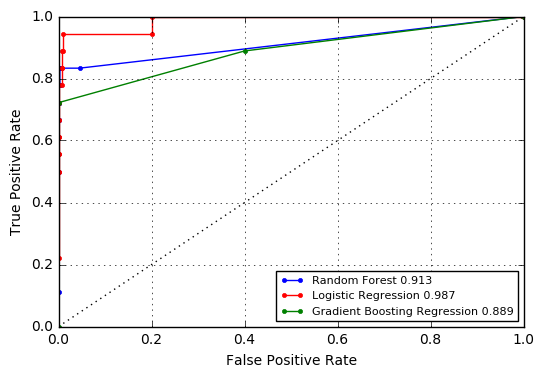

In [62]:
plt.plot([0, 1], [0, 1], 'k:')
plt.plot(fpr_rf, tpr_rf, 'b.-', label='Random Forest %.3f' % (auc_rf))
plt.plot(fpr_lr, tpr_lr, 'r.-', label='Logistic Regression %.3f' % (auc_lr))
plt.plot(fpr_gb, tpr_gb, 'g.-', label='Gradient Boosting Regression %.3f' % (auc_gb))
plt.legend(fontsize=8, loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.show()

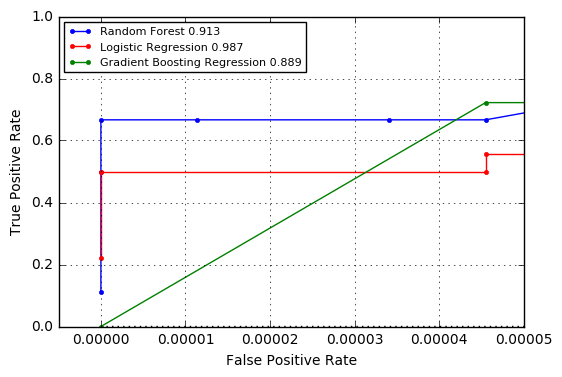

In [85]:
plt.plot([0, 1], [0, 1], 'k:')
plt.plot(fpr_rf, tpr_rf, 'b.-', label='Random Forest %.3f' % (auc_rf))
plt.plot(fpr_lr, tpr_lr, 'r.-', label='Logistic Regression %.3f' % (auc_lr))
plt.plot(fpr_gb, tpr_gb, 'g.-', label='Gradient Boosting Regression %.3f' % (auc_gb))
plt.legend(fontsize=8, loc='upper left')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
xmax = 0.00005
plt.xlim([xmax*-0.1, xmax])
plt.grid()
plt.show()

#### Although Logistic Regression has a higher AUC value, Random Forest seems to have a better deflection point in the ROC curve where FPR is 0 but TPR is at it's highest possible under that condition. Therefore Random Forest, together with that threshold, is selected.

In [79]:
print tpr_rf[:4], fpr_rf[:4], thresholds_rf[:4]
thresh = thresholds_rf[2]
print thresh

[ 0.11111111  0.5         0.66666667  0.66666667] [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.13748820e-05] [ 0.78  0.52  0.44  0.28]
0.44


#### Finally, a random forest model is trained using all data

In [91]:
clf = rf(n_estimators=50, max_features='auto', max_depth=10)
clf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

#### Investigating which features had the highest importance for classification, and using simple histogram plots to observe the differences between passed tests and failed tests for the top two features

#### What is concerning is that the top features are from ALCPT, which is not applicable for 7111 bonds out of 87931 (about 8%). So when testing, if a bond misses ALCPT completely, the features will be filled with the average values from the training set. In turn this could affect performance.

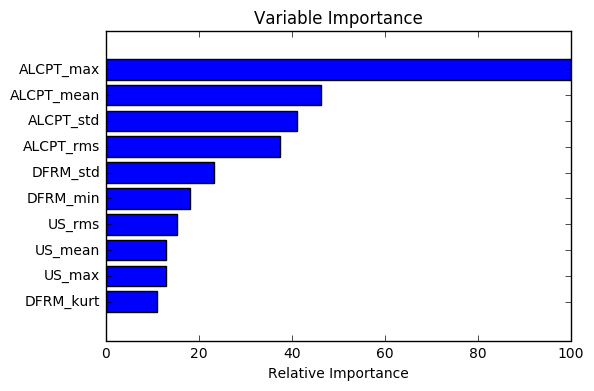

In [128]:
fi = clf.feature_importances_
fi = 100.0 * (fi / fi.max())
sorted_idx = np.argsort(fi)
pos = np.arange(sorted_idx.shape[0]) + .5

pos = pos[-10:]
sorted_idx = sorted_idx[-10:]

plt.barh(pos, fi[sorted_idx], align='center')
plt.yticks(pos, df_feat.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()


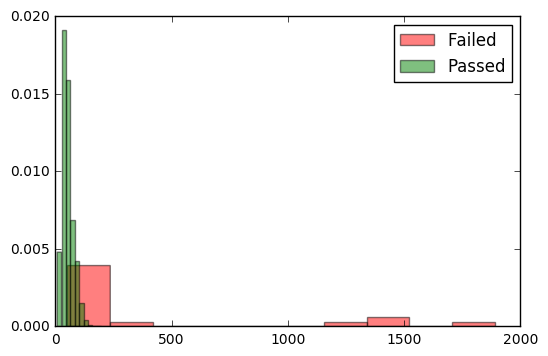

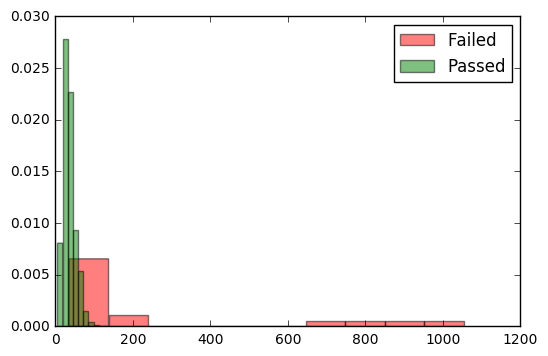

In [137]:
df_labeled = df_feat.copy()
df_labeled['label'] = bond_flag

plt.figure()
plt.hist(df_labeled.loc[df_labeled['label']==1, 'ALCPT_max'], bins=10, color='r', alpha=0.5, normed=True, label='Failed')
plt.hist(df_labeled.loc[df_labeled['label']==0, 'ALCPT_max'], bins=10, color='g', alpha=0.5, normed=True, label='Passed')
plt.legend(loc='best')
plt.show()

plt.figure()
plt.hist(df_labeled.loc[df_labeled['label']==1, 'ALCPT_mean'], bins=10, color='r', alpha=0.5, normed=True, label='Failed')
plt.hist(df_labeled.loc[df_labeled['label']==0, 'ALCPT_mean'], bins=10, color='g', alpha=0.5, normed=True, label='Passed')
plt.legend(loc='best')
plt.show()

#### Exporting the model to a pickle file

In [139]:
joblib.dump(clf, 'rf.pkl')

['rf.pkl']

### Testing
#### Model is used to predict on a new file (file_1 used as an example below), and the performance is printed out. Here, filling the ALCPT features is not included so the test won't run if ALCPT happens to be entirely missing for a bond.
#### Change the file name to test a different file that should be located in the same directory as the notebook

In [172]:
filename = 'Data/file_1.json'
clf = joblib.load('rf.pkl')

with open(filename, 'r') as f:
    data = json.load(f)
f.close()

bonds = data['BONDS']
bond_flag = []
bond_data = []
for bond in bonds:
    test_status_bond = 0 if bond['PULL_TEST_STATUS'] == "Pass" else 1

    sample = bond['TRACE_SAMPLES']
    df = pd.DataFrame.from_dict(sample)

    bond_flag += [test_status_bond]
    bond_data += [df]

y_pred = []
for df in bond_data:
    feat = fe(df)
    df_feat = pd.DataFrame.from_dict([feat])
    X = df_feat.values
    y = clf.predict_proba(X)[0,1]
    y_pred.append(y)

y_pred = (y_pred > thresh).astype(int)

print 'Number of bonds: ', len(bonds)
print 'Classification Report:\n\n', classification_report(bond_flag, y_pred)


Number of bonds:  888
Classification Report:

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       888

avg / total       1.00      1.00      1.00       888

